In [1]:
# Import all required libraries
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from pydantic import BaseModel, Field
from typing import Optional, List
import pandas as pd
from langgraph.graph import StateGraph, END, START
import re

# Load environment
load_dotenv()

# Initialize LLM
llm = ChatGroq(
    model='openai/gpt-oss-120b',
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2
)

In [2]:
# Define Pydantic models
class ColumnSchema(BaseModel):
    transaction_date: str = Field(..., description='Column name for transaction date')
    debit: str = Field(..., description='Column name for debit amount')
    credit: str = Field(..., description='Column name for credit amount')

class BankReconciliationState(BaseModel):
    bank_data: str
    erp_data: str
    bank_columns: Optional[ColumnSchema] = None
    erp_columns: Optional[ColumnSchema] = None
    bank_chunk_data: Optional[List[pd.DataFrame]] = None
    erp_chunk_data: Optional[List[pd.DataFrame]] = None
    erp_chunk_amount: Optional[dict] = None
    bank_chunk_amount: Optional[dict] = None

    model_config = {
        'arbitrary_types_allowed': True
    }

In [3]:
def find_bank_columns(state: BankReconciliationState):
    # Use hardcoded column names based on dataset inspection
    result = ColumnSchema(
        transaction_date='TRN DATE',
        debit='DEBIT',
        credit='CREDIT'
    )
    return {"bank_columns": result}

def find_erp_columns(state: BankReconciliationState):
    # Use hardcoded column names based on dataset inspection
    result = ColumnSchema(
        transaction_date='Date',
        debit='Debit',
        credit='Credit'
    )
    return {"erp_columns": result}

def chunk_dataset(state: BankReconciliationState):
    """Split both datasets into chunks of up to 3 days each."""
    bank_date_column = state.bank_columns.transaction_date
    erp_date_column = state.erp_columns.transaction_date

    # Load datasets
    bank_df = pd.read_csv(state.bank_data)
    erp_df = pd.read_csv(state.erp_data)

    # Ensure transaction_date is datetime
    bank_df[bank_date_column] = pd.to_datetime(bank_df[bank_date_column], errors="coerce")
    erp_df[erp_date_column] = pd.to_datetime(erp_df[erp_date_column], errors="coerce")

    # Drop invalid dates
    bank_df = bank_df.dropna(subset=[bank_date_column])
    erp_df = erp_df.dropna(subset=[erp_date_column])

    def split_by_days(df, date_column):
        if df.empty:
            return []
        df = df.sort_values(by=date_column).reset_index(drop=True)
        min_date, max_date = df[date_column].min(), df[date_column].max()

        if (max_date - min_date).days < 2:
            return [df]

        chunks = []
        start_date = min_date
        while start_date <= max_date:
            end_date = start_date + pd.Timedelta(days=1)
            chunk = df[(df[date_column] >= start_date) & (df[date_column] <= end_date)]
            if not chunk.empty:
                chunks.append(chunk.reset_index(drop=True))
            start_date = end_date + pd.Timedelta(days=1)
        return chunks

    # Split datasets
    bank_chunks = split_by_days(bank_df, bank_date_column)
    erp_chunks = split_by_days(erp_df, erp_date_column)

    # Ensure both have the same number of chunks
    max_chunks = max(len(bank_chunks), len(erp_chunks))
    while len(bank_chunks) < max_chunks:
        bank_chunks.append(pd.DataFrame(columns=bank_df.columns))
    while len(erp_chunks) < max_chunks:
        erp_chunks.append(pd.DataFrame(columns=erp_df.columns))

    # Keep only required columns in each chunk
    required_cols = [bank_date_column, state.bank_columns.debit, state.bank_columns.credit]
    state.bank_chunk_data = [chunk[required_cols].copy() for chunk in bank_chunks]
    state.erp_chunk_data = [chunk[[erp_date_column, state.erp_columns.debit, state.erp_columns.credit]].copy() for chunk in erp_chunks]

    return {
        "bank_chunk_data": state.bank_chunk_data,
        "erp_chunk_data": state.erp_chunk_data
    }

In [ ]:
def reconciliations(state: BankReconciliationState):
    """LLM-powered reconciliation function that generates Python code for calculations."""
    import pandas as pd
    import re
    
    # Take first chunk of each dataset
    bank_df = state.bank_chunk_data[0]
    erp_df = state.erp_chunk_data[0]
    
    # Extract dynamic column names from state
    bank_transaction_date = state.bank_columns.transaction_date
    bank_credit = state.bank_columns.credit
    bank_debit = state.bank_columns.debit
    erp_transaction_date = state.erp_columns.transaction_date
    erp_credit = state.erp_columns.credit
    erp_debit = state.erp_columns.debit
    
    # Create a detailed prompt for the LLM to generate Python code
    bank_sample = bank_df.head(5).to_string() if not bank_df.empty else "No data"
    erp_sample = erp_df.head(5).to_string() if not erp_df.empty else "No data"
    
    prompt = f"""You are a financial analyst. Write Python code to calculate net balance for two datasets.

Bank dataset columns:
- Transaction date: "{bank_transaction_date}"
- Debit: "{bank_debit}" 
- Credit: "{bank_credit}"

ERP dataset columns:
- Transaction date: "{erp_transaction_date}"
- Debit: "{erp_debit}"
- Credit: "{erp_credit}"

Sample bank data:
{bank_sample}

Sample ERP data:
{erp_sample}

Task: Write Python code to calculate net balance (total_credit - total_debit) for bank dataset and (total_debit - total_credit) for erp dataset.

Requirements:
1. Convert columns to numeric, handling commas and NaN values as 0
2. Calculate: bank_net_balance = bank_total_credit - bank_total_debit
3. Calculate: erp_net_balance = erp_total_debit - erp_total_credit 
4. Use the exact column names provided above
5. Return only executable Python code, no explanations or markdown

Example format:
# Clean bank data
bank_df['{bank_credit}'] = pd.to_numeric(bank_df['{bank_credit}'].astype(str).str.replace(',', ''), errors='coerce').fillna(0)
bank_df['{bank_debit}'] = pd.to_numeric(bank_df['{bank_debit}'].astype(str).str.replace(',', ''), errors='coerce').fillna(0)
bank_total_credit = bank_df['{bank_credit}'].sum()
bank_total_debit = bank_df['{bank_debit}'].sum()
bank_net_balance = bank_total_credit - bank_total_debit

# Clean ERP data
erp_df['{erp_credit}'] = pd.to_numeric(erp_df['{erp_credit}'], errors='coerce').fillna(0)
erp_df['{erp_debit}'] = pd.to_numeric(erp_df['{erp_debit}'], errors='coerce').fillna(0)
erp_total_credit = erp_df['{erp_credit}'].sum()
erp_total_debit = erp_df['{erp_debit}'].sum()
erp_net_balance = erp_total_debit - erp_total_credit"""
    
    try:
        # Use regular LLM instead of structured output to avoid tool choice errors
        from langchain_core.messages import HumanMessage
        response = llm.invoke([HumanMessage(content=prompt)])
        code = response.content
        
        # Clean the response (remove markdown code blocks if present)
        code = re.sub(r'```python\n?', '', code)
        code = re.sub(r'\n?```', '', code)
        code = code.strip()
        
        print(f"🤖 LLM Generated Reconciliation Code:")
        print(code)
        print("=" * 50)
        
        # Execute the LLM-generated code in a safe scope
        local_vars = {"bank_df": bank_df.copy(), "erp_df": erp_df.copy(), "pd": pd}
        exec(code, {"pd": pd}, local_vars)
        
        # Extract variables from executed code
        bank_net_balance = local_vars.get("bank_net_balance")
        erp_net_balance = local_vars.get("erp_net_balance")
        
        if bank_net_balance is None or erp_net_balance is None:
            raise ValueError("LLM code did not produce required variables")
        
        # Save results in state
        state.bank_chunk_amount = bank_net_balance
        state.erp_chunk_amount = erp_net_balance
        
        print(f"💰 LLM Calculated - Bank total: {bank_net_balance}, ERP total: {erp_net_balance}")
        
    except Exception as e:
        print(f"⚠️ LLM calculation failed: {e}")
        print("🔄 Falling back to hardcoded calculation...")
        
        # Fallback to hardcoded calculation if LLM fails
        bank_df[bank_credit] = pd.to_numeric(bank_df[bank_credit].astype(str).str.replace(',', '').replace('nan', '0'), errors='coerce').fillna(0)
        bank_df[bank_debit] = pd.to_numeric(bank_df[bank_debit].astype(str).str.replace(',', '').replace('nan', '0'), errors='coerce').fillna(0)
        bank_total_credit = bank_df[bank_credit].sum()
        bank_total_debit = bank_df[bank_debit].sum()
        bank_net_balance = bank_total_credit - bank_total_debit
        
        erp_df[erp_credit] = pd.to_numeric(erp_df[erp_credit], errors='coerce').fillna(0)
        erp_df[erp_debit] = pd.to_numeric(erp_df[erp_debit], errors='coerce').fillna(0)
        erp_total_credit = erp_df[erp_credit].sum()
        erp_total_debit = erp_df[erp_debit].sum()
        erp_net_balance = erp_total_credit - erp_total_debit
        
        state.bank_chunk_amount = bank_net_balance
        state.erp_chunk_amount = erp_net_balance
        
        print(f"💰 Fallback Calculated - Bank total: {bank_net_balance}, ERP total: {erp_net_balance}")
    
    return state

print("✅ Helper functions defined")


✅ Helper functions defined


In [5]:

# Build workflow
print("\n🔧 Building workflow...")
graph = StateGraph(BankReconciliationState)

# Add nodes
graph.add_node("find_bank_columns", find_bank_columns)
graph.add_node("find_erp_columns", find_erp_columns)
graph.add_node("chunk_dataset", chunk_dataset)
graph.add_node("reconciliations", reconciliations)

# Connect edges
graph.add_edge(START, "find_bank_columns")
graph.add_edge(START, "find_erp_columns")
graph.add_edge("find_bank_columns", "chunk_dataset")
graph.add_edge("find_erp_columns", "chunk_dataset")
graph.add_edge("chunk_dataset", "reconciliations")
graph.add_edge("reconciliations", END)

# Compile workflow
workflow = graph.compile()
print("✅ Workflow built and compiled")



🔧 Building workflow...
✅ Workflow built and compiled


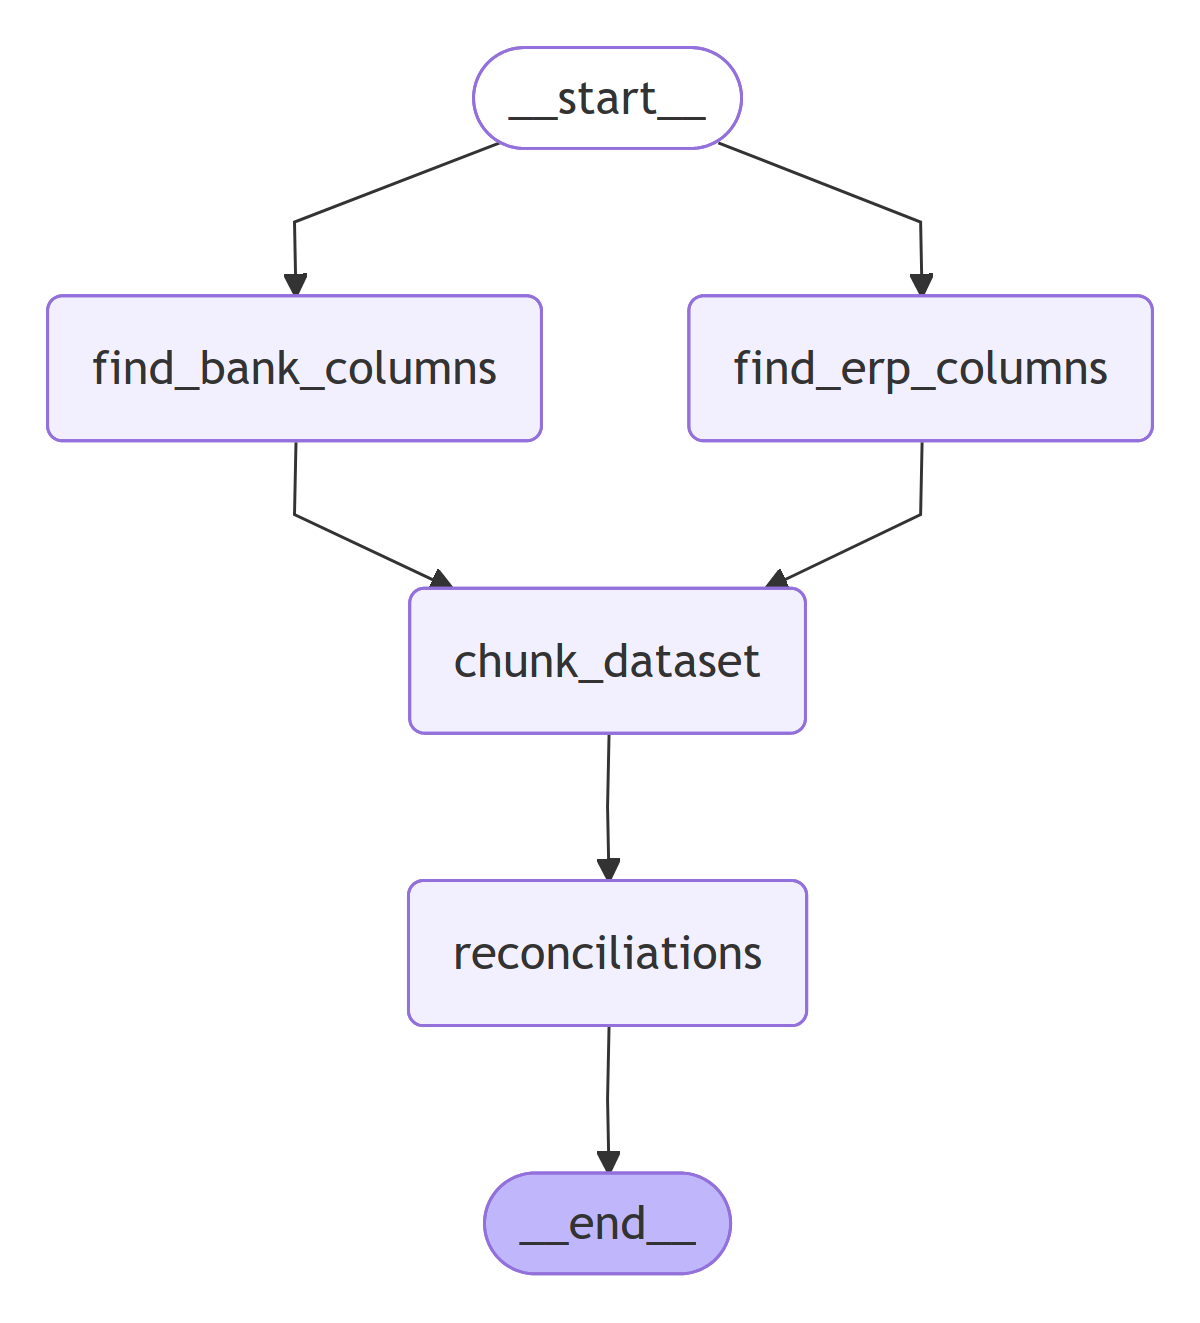

In [6]:
# from IPython.display import Image, display
# Image(workflow.get_graph().draw_mermaid_png())


import nest_asyncio
from IPython.display import Image, display
from langchain_core.runnables.graph_mermaid import MermaidDrawMethod

nest_asyncio.apply()  # patch the running event loop

# Render workflow graph locally
png = workflow.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)
display(Image(png))


In [7]:
initial_state = {
    "erp_data": "Dataset/Pubali # 41774-ERP.csv",
    "bank_data": "Dataset/Pubali # 41774.csv"
}

try:
    result = workflow.invoke(initial_state)
    print("✅ Workflow executed successfully")
    
    print("\n📋 Results:")
    print("Bank Columns:", result["bank_columns"])
    print("ERP Columns:", result["erp_columns"])
    
    bank_columns = result["bank_columns"]
    erp_columns = result["erp_columns"]
    
    print(f"\n🏦 Bank columns - Date: {bank_columns.transaction_date}, Debit: {bank_columns.debit}, Credit: {bank_columns.credit}")
    print(f"🏢 ERP columns - Date: {erp_columns.transaction_date}, Debit: {erp_columns.debit}, Credit: {erp_columns.credit}")
    
    print(f"\nBank chunk amount: {result['bank_chunk_amount']}")
    print(f"ERP chunk amount: {result['erp_chunk_amount']}")
    
except Exception as e:
    print(f"❌ Error running workflow: {e}")
    import traceback
    traceback.print_exc()


🤖 LLM Generated Reconciliation Code:
import pandas as pd

# Assume bank_df and erp_df are already defined DataFrames

# Clean Bank data
bank_df['CREDIT'] = (
    pd.to_numeric(
        bank_df['CREDIT'].astype(str).str.replace(',', ''), errors='coerce'
    ).fillna(0)
)
bank_df['DEBIT'] = (
    pd.to_numeric(
        bank_df['DEBIT'].astype(str).str.replace(',', ''), errors='coerce'
    ).fillna(0)
)

bank_total_credit = bank_df['CREDIT'].sum()
bank_total_debit = bank_df['DEBIT'].sum()
bank_net_balance = bank_total_credit - bank_total_debit

# Clean ERP data
erp_df['Credit'] = (
    pd.to_numeric(
        erp_df['Credit'].astype(str).str.replace(',', ''), errors='coerce'
    ).fillna(0)
)
erp_df['Debit'] = (
    pd.to_numeric(
        erp_df['Debit'].astype(str).str.replace(',', ''), errors='coerce'
    ).fillna(0)
)

erp_total_credit = erp_df['Credit'].sum()
erp_total_debit = erp_df['Debit'].sum()
erp_net_balance = erp_total_debit - erp_total_credit

# Results
print(f"Bank Net Balance

In [8]:
bank_columns = result["bank_columns"]
erp_columns = result["erp_columns"]

In [9]:
# Option 1: Access each value individually
transaction_date = bank_columns.transaction_date
debit = bank_columns.debit
credit = bank_columns.credit

print(transaction_date, "\n", debit, "\n", credit)

TRN DATE 
 DEBIT 
 CREDIT


In [10]:
# Option 1: Access each value individually
transaction_date = erp_columns.transaction_date
debit = erp_columns.debit
credit = erp_columns.credit

print(transaction_date, "\n", debit, "\n", credit)

Date 
 Debit 
 Credit


In [18]:
result["bank_chunk_amount"]

355820.0

In [21]:
df = pd.DataFrame(result["bank_chunk_data"][0])

# Convert CREDIT column to numeric (removes commas, handles NaN as 0)
df["CREDIT"] = (
    df["CREDIT"]
    .astype(str)                 # ensure string for replace
    .str.replace(",", "", regex=False)  # remove commas
    .replace("nan", "0")         # handle string "nan"
    .astype(float)               # convert to float
    .fillna(0)                   # handle actual NaN
)

# Now sum the CREDIT column
total_credit = df["CREDIT"].sum()

print("Total CREDIT:", total_credit)

Total CREDIT: 5655820.0


In [22]:
df = pd.DataFrame(result["bank_chunk_data"][0])

# Convert CREDIT column to numeric (removes commas, handles NaN as 0)
df["DEBIT"] = (
    df["DEBIT"]
    .astype(str)                 # ensure string for replace
    .str.replace(",", "", regex=False)  # remove commas
    .replace("nan", "0")         # handle string "nan"
    .astype(float)               # convert to float
    .fillna(0)                   # handle actual NaN
)

# Now sum the CREDIT column
total_credit = df["DEBIT"].sum()

print("Total DEBIT:", total_credit)

Total DEBIT: 5300000.0


In [23]:
df = pd.DataFrame(result["erp_chunk_data"][0])

# Convert CREDIT column to numeric (removes commas, handles NaN as 0)
df["Credit"] = (
    df["Credit"]
    .astype(str)                 # ensure string for replace
    .str.replace(",", "", regex=False)  # remove commas
    .replace("nan", "0")         # handle string "nan"
    .astype(float)               # convert to float
    .fillna(0)                   # handle actual NaN
)

# Now sum the CREDIT column
total_credit = df["Credit"].sum()

print("Total Credit:", total_credit)

Total Credit: 5300000.0


In [15]:
df = pd.DataFrame(result["erp_chunk_data"][0])

# Convert CREDIT column to numeric (removes commas, handles NaN as 0)
df["Debit"] = (
    df["Debit"]
    .astype(str)                 # ensure string for replace
    .str.replace(",", "", regex=False)  # remove commas
    .replace("nan", "0")         # handle string "nan"
    .astype(float)               # convert to float
    .fillna(0)                   # handle actual NaN
)

# Now sum the CREDIT column
total_credit = df["Debit"].sum()

print("Total Debit:", total_credit)

Total Debit: 5655820.0


In [25]:
df = pd.DataFrame(result["erp_chunk_data"][0])

# Convert CREDIT column to numeric (removes commas, handles NaN as 0)
df["Credit"] = (
    df["Credit"]
    .astype(str)                 # ensure string for replace
    .str.replace(",", "", regex=False)  # remove commas
    .replace("nan", "0")         # handle string "nan"
    .astype(float)               # convert to float
    .fillna(0)                   # handle actual NaN
)

# Now sum the CREDIT column
total_credit = df["Credit"].sum()

print("Total Credit:", total_credit)

Total Credit: 5300000.0
